# Case Study 1 :-  Quora question Pair Similarity Problem

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 



<h2> Problem Statement </h2>

- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 


- More formally, the duplicate detection problem can be defined as follows: given a pair of questions q1 and q2, train a model that learns the function:

f(q1, q2) → 0 or 1

where 1 represents that q1 and q2 have the same intent and 0 otherwise.

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
People would not trust quora if there is a misclassification.


2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
we could set a high threshold and say if probability is greater than that threshold only then merge or classify the answers as same.
Why there is a need of probability scores? 
Ans - since we know the cost of misclassification is very and simply predicting 0-1 would not help us because we need to set high threshold and that's why we use probability scores only then we could set threshold like if probability is greater than 0.99 then predict 1 else 0


3. No strict latency concerns.
Quora can take secs to give answers


4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

Since we have to predict between 0 and 1 its a binary classification problem 

## Performance Indicatior

1. log-loss : (KPI-Key Performance Indicator)- Since we need probability value log-loss is the best metric
2. Binary Confusion Matrix

### importing required dependencies

In [65]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import time
from sqlalchemy import create_engine # database connection
import csv
import datetime as dt
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import defaultdict

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
import random

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h2> 3.1 Reading data</h2>

In [66]:
os.chdir("D:\\firefox downloads\\Quora")
quora = pd.read_csv("train.csv")

In [67]:
print(f"Now of rows : {quora.shape[0]} and Number of columns : {quora.shape[1]}")

Now of rows : 404290 and Number of columns : 6


In [68]:
#quora = quora.sample(100000)

In [69]:
quora.shape

(404290, 6)

In [70]:
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


1. qid1 = Id of question 1

2. qid2 = Id of question 2

3. question1 and question2 = self explanatory

4. id_duplicate = our output label where 0 indicates different question and 1 indicates same question 

In [71]:
quora.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We have 1 null value in question1 and 2 null values in question2

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

(array([0, 1]), <a list of 2 Text xticklabel objects>)

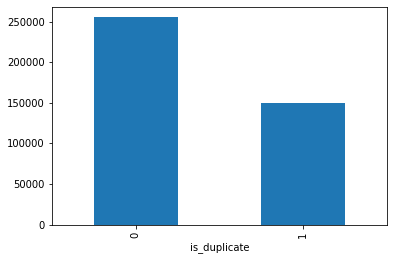

In [72]:
quora.groupby("is_duplicate")["id"].count().plot.bar()
plt.xticks(rotation=90) 

In [73]:
zeros = quora["is_duplicate"].value_counts()[0]
ones = quora["is_duplicate"].value_counts()[1]

In [74]:
quora["is_duplicate"].count() 

404290

In [75]:
percent_one = 100*(ones/quora["is_duplicate"].count())
percent_zero = 100*(zeros/quora["is_duplicate"].count()) 

In [76]:
print(f"percentage of ones: {percent_one}%\npercentage of zeros: {percent_zero}%") 

percentage of ones: 36.9197853026293%
percentage of zeros: 63.08021469737069%


We can see that the number on question which are similar is around 37% and question which are different to each other is 63%

In [77]:
print(quora.shape)
#print(y_true.shape)

(404290, 6)


<h3> 3.2.2 Number of unique questions </h3>

In [78]:
qids = pd.Series(quora['qid1'].tolist() + quora['qid2'].tolist())  #tolist function converts qid's into a list and merges to one then we are converting it into series
#print(type(qids))
unique_ques = qids.nunique()  #finding unique questions
print(f"total number of unique questions are : {unique_ques}")

ques_more_than_once = (qids.value_counts()>1).sum()  #calculating the sum of values greater than 1 ....means we are summing all those qids whose value greater than 1 
print(f"Number of questions that appeared more than once : {ques_more_than_once} i.e around : {(ques_more_than_once/unique_ques)*100}%")

print(f"Maximum number a single question is appeared :{max(qids.value_counts())}")

total number of unique questions are : 537933
Number of questions that appeared more than once : 111780 i.e around : 20.77953945937505%
Maximum number a single question is appeared :157


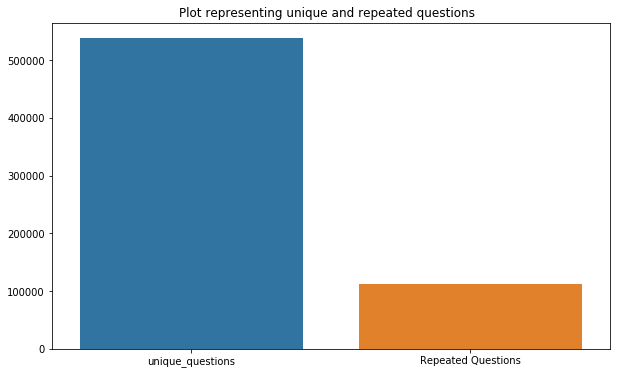

In [79]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ques , ques_more_than_once]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

We can see that around 80% of the questions are unique questions and 20% repeated questions

<h3>3.2.3 Checking for Duplicates Pairs in a Row </h3>

In [80]:
#checking whether there are any repeated pair of questions

pair_duplicates = quora[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - quora.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



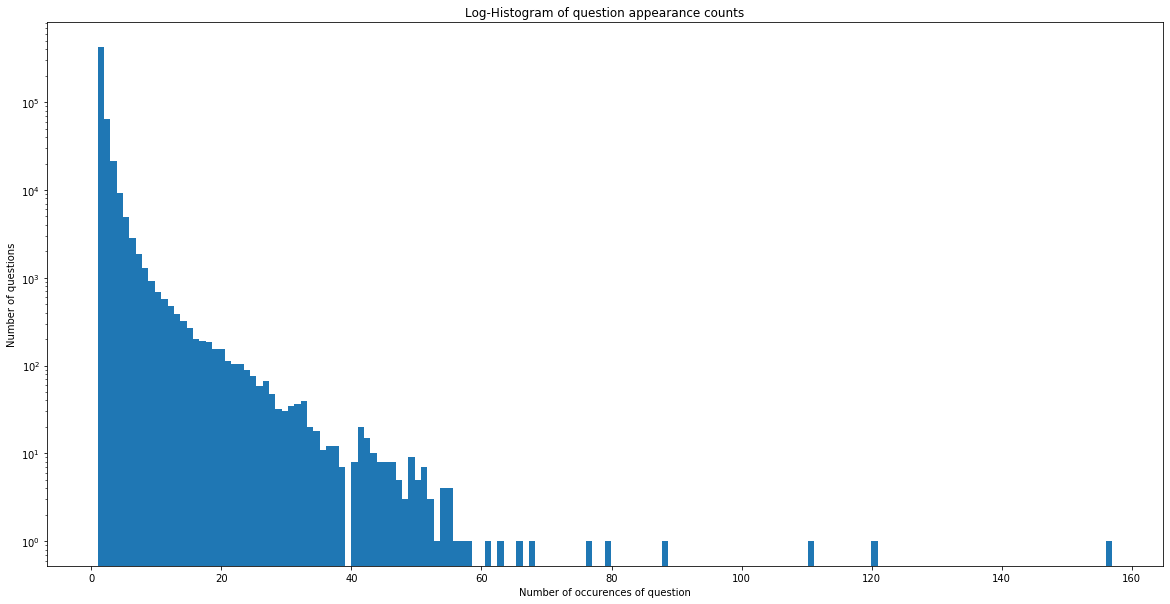

In [81]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

The above plot has a log of y-axis and on x-axis we can see that number of occurences of questions

Since most of the questions are unique i.e not repeating and hence we can see that x-axis = 0 the longest line

and some questions are repeated like one is repeated 157times and one 120times etc

<h3> 3.2.5 Checking for NULL values </h3>

In [82]:
nan_rows = quora[quora.isnull().any(1)] #chewcking rows which are null values 

In [83]:
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [84]:
# Filling those null values with ' '
quora = quora.fillna('')
nan_rows = quora[quora.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [85]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We can confirmed that our null values have been taken care of

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:

1. freq_qid1 = Frequency of qid1's
2. freq_qid2 = Frequency of qid2's
3. q1len = Length of q1
4. q2len = Length of q2
5. q1_n_words = Number of words in Question 1
6. q2_n_words = Number of words in Question 2
7. word_Common = (Number of common unique words in Question 1 and Question 2)
8. word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
9. word_share = (word_common)/(word_Total)
10. freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
11. freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [86]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    quora = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    quora['freq_qid1'] = quora.groupby('qid1')['qid1'].transform('count')
    #.tranform function in python ? - https://www.geeksforgeeks.org/python-pandas-dataframe-transform/ 
    quora['freq_qid2'] = quora.groupby('qid2')['qid2'].transform('count')
    quora['q1len'] = quora['question1'].str.len()
    #.str.len function - https://www.geeksforgeeks.org/python-pandas-series-str-len/ 
    quora['q2len'] = quora['question2'].str.len()
    quora['q1_n_words'] = quora['question1'].apply(lambda row: len(row.split(" ")))
    quora['q2_n_words'] = quora['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    quora['word_Common'] = quora.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    quora['word_Total'] = quora.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    quora['word_share'] = quora.apply(normalized_word_share, axis=1)

    quora['freq_q1+q2'] = quora['freq_qid1']+quora['freq_qid2']
    quora['freq_q1-q2'] = abs(quora['freq_qid1']-quora['freq_qid2'])

    quora.to_csv("df_fe_without_preprocessing_train.csv", index=False)

quora.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysing some of the extracted features </h3>

#### Question with single words

In [87]:
print ("Minimum length of the questions in question1 : " , min(quora['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(quora['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", quora[quora['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", quora[quora['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### word_share

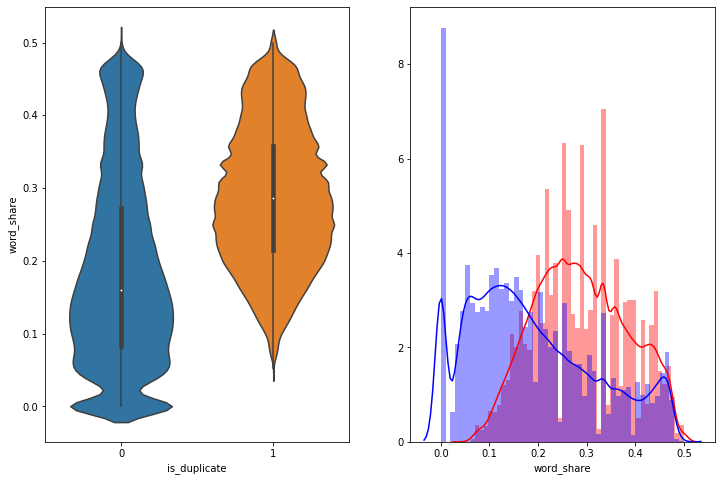

In [88]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = quora[0:])

plt.subplot(1,2,2)
sns.distplot(quora[quora['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(quora[quora['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

1. By looking at the violin plot we can somewhat differentiate between the two classes... when the word share is high there are more chances of questions being similar

#### word_common

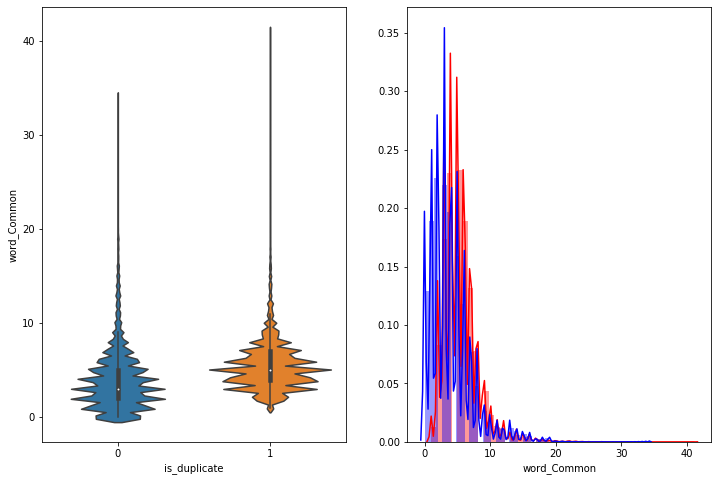

In [89]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = quora[0:])

plt.subplot(1,2,2)
sns.distplot(quora[quora['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(quora[quora['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

Distribution is pretty much overlapped and hence harder to distinguish between the two classes based on word_common feature

### Text Preprocessing

Preprocessing of text includes
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [90]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english") #getting all the stopwords in a variable stop_words


def preprocess(x): #creating a function preprocess 
    x = str(x).lower() ##converting into lower
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


e.g. He sat on the wall

tokens are {he , sat , on , the , wall}

stop_wrods {he, on  , the}

word {sat , wall }

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [91]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [92]:
if os.path.isfile('nlp_features_train.csv'):
    quora1 = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    quora1.fillna('')
else:
    print("Extracting features for train:")
    quora1 = pd.read_csv("train.csv")
    quora1 = extract_features(X_train) 
    quora1.to_csv("nlp_features_train.csv", index=False)
quora1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [93]:
quora1.drop(["qid1","qid2","question1","question2","is_duplicate"],axis=1,inplace=True)

In [94]:
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [95]:
quora = quora.merge(quora1, on='id',how='left')
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [96]:
quora.shape

(404290, 32)

<h3>3.5.1 Analysis of extracted features </h3>

#### Word Cloud

In [97]:
df_duplicate =quora[quora['is_duplicate'] == 1]
dfp_nonduplicate = quora[quora['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding="utf-8") 

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


error = UnicodeEncodeError: 'charmap' codec can't encode characters

Solved = "https://stackoverflow.com/questions/27092833/unicodeencodeerror-charmap-codec-cant-encode-characters"

In [98]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding="utf-8").read() 
textn_w = open(path.join(d, 'train_n.txt'), encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16087608
Total number of words in non duplicate pair questions : 33092299


Word Cloud for Duplicate Question pairs


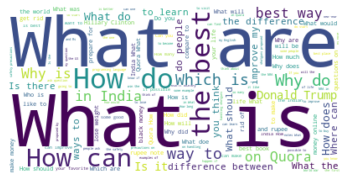

In [99]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

1. In duplicate Question pairs we can see that words like "The best" "best way" "on quora" "in india" dominating


Word Cloud for non-Duplicate Question pairs:


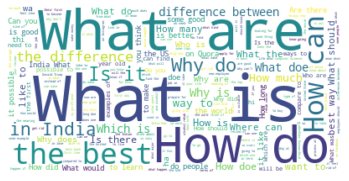

In [100]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In non-duplicate words we can see the words dominating are "the best" "in india" "doe"

One thing we can observe that word "in india" is present in both the clouds but in non-duplicate cloud "in india" is more stronger

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

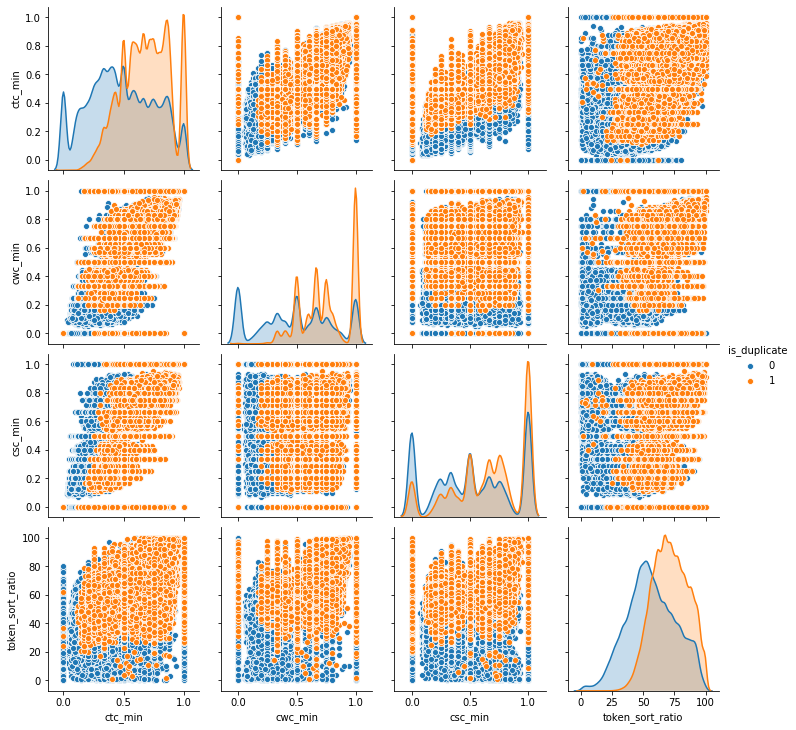

In [101]:
n = quora.shape[0]
sns.pairplot(quora[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

Observation from above plot

1. in ctc_min :as ctc_min increase we have more of duplicate questions than non-duplicates

2. when we see the scatter plot between csc_min and ctc_min we can separate the two class labels that is as we move more towards right we can see more of duplicate questions

3. similary seeing the distribution plot of token_sort_ratio there is partial separability between class labels; as we go higher we can see more of duplicate questions 

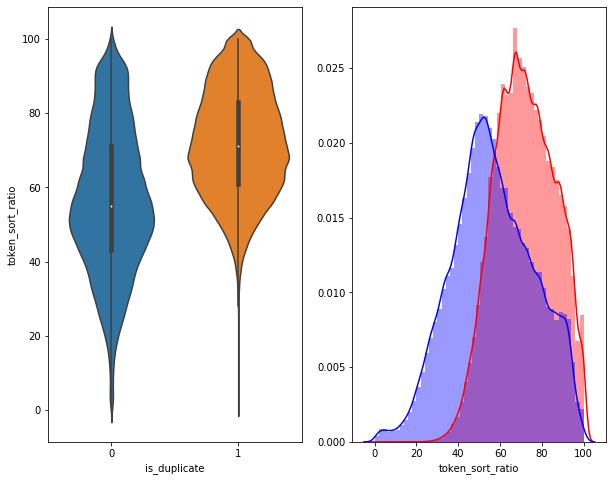

In [102]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = quora[0:] , )

plt.subplot(1,2,2)
sns.distplot(quora[quora['is_duplicate'] == 1.0]['token_sort_ratio'][0:] ,label = "1", color = 'red')
sns.distplot(quora[quora['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

As we can see that as the value of token_sort_ratio increases the chances of seeing duplicate questions are higher


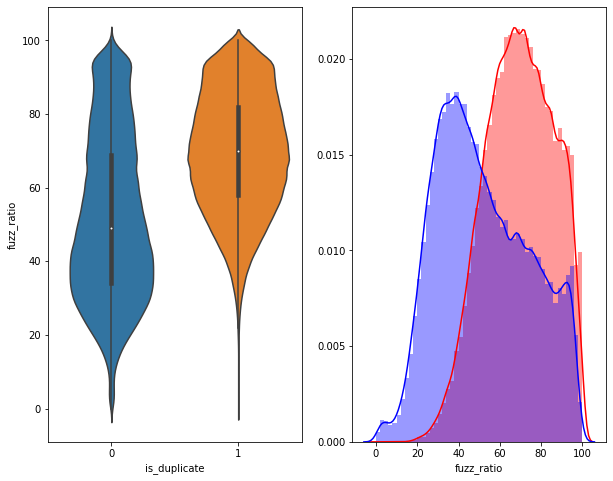

In [103]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = quora[0:] , )

plt.subplot(1,2,2)
sns.distplot(quora[quora['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(quora[quora['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

as fuzz_ratio increases chances of seeing duplicate questions is more 

<h3>3.5.2 Visualization </h3>

In [104]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = quora[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [105]:
tsne2d = TSNE(
    n_components=2, #no of dimensions we need 
    #derfault perplexity = 30 
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.174s
[t-SNE] Iteration 50: error = 81.3441315, gradient norm = 0.0466835 (50 iterations in 1.003s)
[t-SNE] Iteration 100: error = 70.6513290, gradient norm = 0.0087385 (50 iterations in 0.916s)
[t-SNE] Iteration 150: error = 68.9513779, gradient norm = 0.0055224 (50 iterations in 0.900s)
[t-SNE] Iteration 200: error = 68.1307220, gradient norm = 0.0044136 (50 iterations in 0.934s)
[t-SNE] Iteration 250: error = 67.6241913, gradient norm = 0.0040027

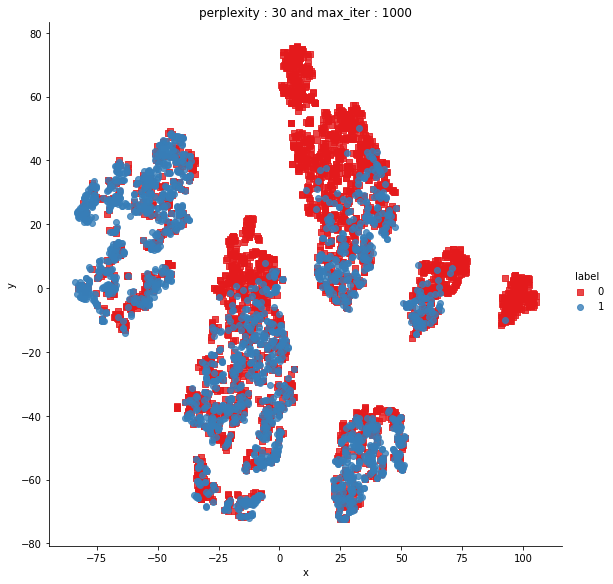

In [106]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [107]:
tsne2d = TSNE(
    n_components=2, #no of dimensions we need 
    perplexity=60.0 ,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.161027
[t-SNE] Computed conditional probabilities in 0.355s
[t-SNE] Iteration 50: error = 72.8174667, gradient norm = 0.0393788 (50 iterations in 1.390s)
[t-SNE] Iteration 100: error = 64.0111694, gradient norm = 0.0107594 (50 iterations in 1.199s)
[t-SNE] Iteration 150: error = 62.7541313, gradient norm = 0.0047035 (50 iterations in 1.260s)
[t-SNE] Iteration 200: error = 62.2039948, gradient norm = 0.0033373 (50 iterations in 1.269s)
[t-SNE] Iteration 250: error = 61.8781242, gradient norm = 0.003630

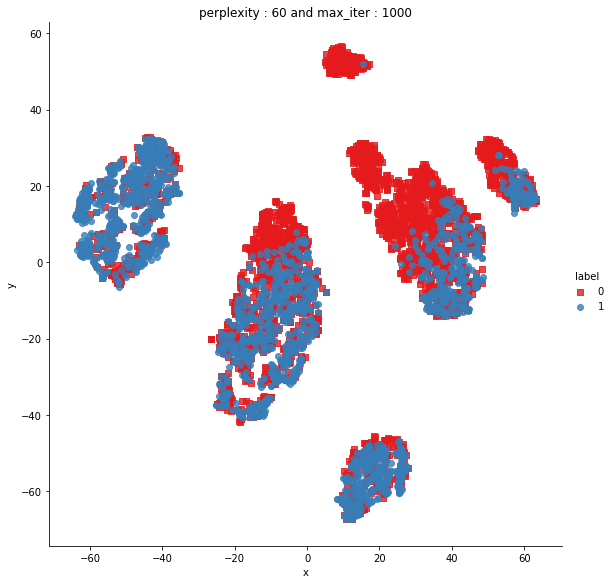

In [108]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(60, 1000))
plt.show()

At perplexity 100 and iteration of around 1000 we can see that we can somewhat separate our features based on class labels

In [109]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.180s
[t-SNE] Iteration 50: error = 80.5758362, gradient norm = 0.0296225 (50 iterations in 1.957s)
[t-SNE] Iteration 100: error = 69.4230347, gradient norm = 0.0033213 (50 iterations in 1.412s)
[t-SNE] Iteration 150: error = 68.0058212, gradient norm = 0.0017131 (50 iterations in 1.305s)
[t-SNE] Iteration 200: error = 67.4458008, gradient norm = 0.0011530 (50 iterations in 1.457s)
[t-SNE] Iteration 250: error = 67.1337357, gradient norm = 0.0009050

In [110]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## Splitting into train and test data

In [111]:
quora.shape

(404290, 32)

In [112]:
quora = quora.sample(100000)
quora.shape

(100000, 32)

In [113]:
y_true = quora["is_duplicate"]
y_true.shape

(100000,)

In [114]:
quora.drop(["is_duplicate"],axis = 1 , inplace= True)
quora.shape

(100000, 31)

In [115]:
X_train,X_test, y_train , y_test = train_test_split(quora, y_true , stratify = y_true, test_size=0.3, random_state = 23) #splitting in the ratio 70:30 ratio
print("Number of data points in train data :",X_train.shape)
print("Number of data points in train data :",y_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in test data :",y_test.shape)

Number of data points in train data : (70000, 31)
Number of data points in train data : (70000,)
Number of data points in test data : (30000, 31)
Number of data points in test data : (30000,)


## Converting text to numerical vectors using tfidf

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
X_train["questions_train"] = X_train['question1'] + X_train['question2']
X_test["questions_test"] = X_test['question1'] + X_test['question2']

tfidf = TfidfVectorizer(lowercase=False,max_features=2000)
tfidf.fit(X_train["questions_train"].values.astype("U"))#quora["questions"].values.astype('U'))

transformed_train = tfidf.transform(X_train["questions_train"].values.astype("U"))

transformed_test = tfidf.transform(X_test["questions_test"].values.astype("U")) 

In [117]:
print(transformed_train.shape)
print(transformed_test.shape)

(70000, 2000)
(30000, 2000)


In [118]:
testing = tfidf.get_feature_names()
len(testing)

2000

google search for - > ccreating a dataframe from an tfidf

https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe

In [119]:
df_train = pd.DataFrame(transformed_train.toarray(), columns=tfidf.get_feature_names())
print(df_train.shape)
print(df_train.head())

(70000, 2000)
   000   10  100  1000   11   12  12th   13   14   15  ...  years  yes  yet  \
0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   

        you  young  your  yourself  youtube  zero  zone  
0  0.000000    0.0   0.0       0.0      0.0   0.0   0.0  
1  0.000000    0.0   0.0       0.0      0.0   0.0   0.0  
2  0.000000    0.0   0.0       0.0      0.0   0.0   0.0  
3  0.000000    0.0   0.0       0.0      0.0   0.0   0.0  
4  0.267501    0.0   0.0       0.0      0.0   0.0   0.0  

[5 rows x 2000 columns]


In [120]:
df_train.shape

(70000, 2000)

In [121]:
df_test = pd.DataFrame(transformed_test.toarray(), columns=tfidf.get_feature_names())
print(df_test.shape)

(30000, 2000)


In [122]:
X_train.index = df_train.index

In [123]:
final_train = pd.merge(X_train, df_train, left_index=True, right_index=True)

In [124]:
final_train.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,years,yes,yet,you,young,your,yourself,youtube,zero,zone
0,282871,402892,68310,Can I link my Google adsense to my YouTube cha...,What are the applications and limitations of a...,1,1,78,101,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,220551,59099,66132,What do the rest of the Indians think about Ka...,What do people from other states think of Kann...,1,3,55,53,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
final_train.drop(['id', 'qid1', 'qid2', 'question1', 'question2',"questions","questions_train"],axis = 1, inplace=True)


In [127]:
print(X_test.shape)
print(df_test.shape)

(30000, 32)
(30000, 2000)


In [128]:
X_test.index = df_test.index 

In [129]:
final_test = pd.merge(X_test, df_test, left_index=True, right_index=True)
final_test.shape

(30000, 2032)

In [130]:
final_test.drop(['id', 'qid1', 'qid2', 'question1', 'question2',"questions","questions_test"],axis = 1, inplace=True)
final_test.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,years,yes,yet,you,young,your,yourself,youtube,zero,zone
0,1,1,45,39,11,8,1.0,18.0,0.055556,2,...,0.0,0.0,0.0,0.000000,0.0,0.331219,0.0,0.0,0.0,0.0
1,5,11,77,39,15,9,5.0,24.0,0.208333,16,...,0.0,0.0,0.0,0.127298,0.0,0.000000,0.0,0.0,0.0,0.0


In [131]:
print(f"Train:\n{final_train.shape},{y_train.shape}")

Train:
(70000, 2025),(70000,)


In [132]:
print(f"Test:\n{final_test.shape},{y_test.shape}")

Test:
(30000, 2025),(30000,)


In [133]:
#saving both test and train into a csv

final_train.to_csv("final_train.csv")
final_test.to_csv("final_test.csv")

<h2> 4.2 Converting strings to numerics </h2>

In [135]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(final_train.columns)
for i in cols:
    final_train[i] = final_train[i].apply(pd.to_numeric)
    #print(i)

In [136]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_train = list(map(int, y_train.values))

In [137]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(final_test.columns)
for i in cols:
    final_test[i] = final_test[i].apply(pd.to_numeric)
    #print(i)

In [138]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_test = list(map(int, y_test.values))

In [139]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6305142857142857 Class 1:  0.3694857142857143
---------- Distribution of output variable in test data ----------
Class 0:  0.6305 Class 1:  0.3695


Distribution of output class is same in both the test and train output labels

Counter function in python -> Using the Python Counter tool, you can count the key-value pairs in an object, also called a hashtable object

<h2>Selecting the top k(=800) Features </h2>

https://www.kaggle.com/jepsds/feature-selection-using-selectkbest?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [140]:
from sklearn.feature_selection import SelectKBest, chi2

In [141]:
best_features = SelectKBest(score_func=chi2,k=800)
best_features.fit(final_train,y_train)

best_train = best_features.transform(final_train)
best_test = best_features.transform(final_test)

In [142]:
best_train.shape

(70000, 800)

In [143]:
best_test.shape

(30000, 800)

In [144]:
best_features.scores_[0:10]

array([ 56943.76994254,  46643.10590525,  31965.34732529,  36557.35327861,
         4680.06914226,   6721.47249658,   8067.25086732,   8589.42398338,
          772.79237049, 103090.49267637])

## Creating a function to plot confusion matrix

In [145]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

What is the use of random model?


Random model is a model which is used to compare our models performance. Say we our random model has a loss of 0.6 then we want to build a model which performs better than this model. So our random model acts a worst-case model

Log loss on Test Data using Random Model 0.888163041520817


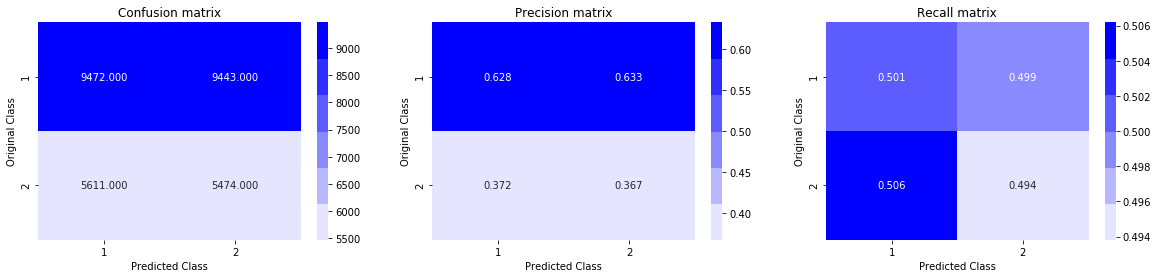

In [146]:
from sklearn.metrics.classification import accuracy_score, log_loss
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h1>4. Machine Learning Models </h1>

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.44742710579936495
For values of alpha =  0.0001 The log loss is: 0.45649415215019895
For values of alpha =  0.001 The log loss is: 0.454732689300223
For values of alpha =  0.01 The log loss is: 0.43764268751596014
For values of alpha =  0.1 The log loss is: 0.450393532928286
For values of alpha =  1 The log loss is: 0.48738330031480365
For values of alpha =  10 The log loss is: 0.5366106082913842


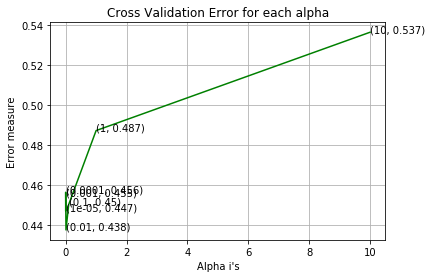

For values of best alpha =  0.01 The train log loss is: 0.4332990184313027
For values of best alpha =  0.01 The test log loss is: 0.43764268751596014
Total number of data points : 30000


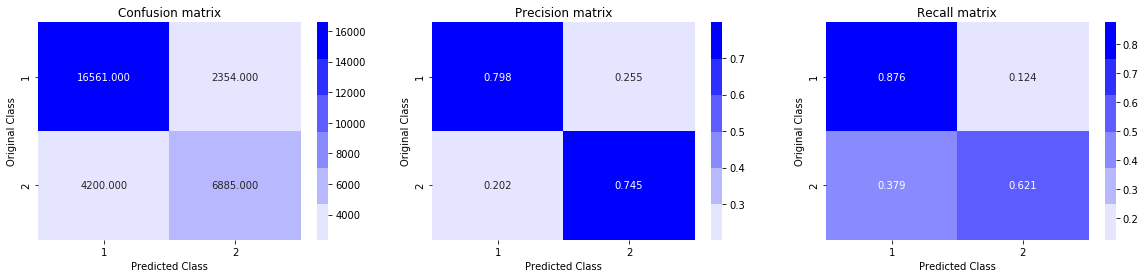

In [147]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(best_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(best_train, y_train)
    predict_y = sig_clf.predict_proba(best_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(best_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(best_train, y_train)

predict_y = sig_clf.predict_proba(best_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(best_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

1. In the graph of alpha i's Vs Error Measure; we see that on x-axis we have different alpha values and on y-axis we have its corresponding error(log-loss) and we can see that for the the alpha value of 0.01 we get the lowest error.

Train and Test Loss is very close to each other represents that our model is neither underfitting nor overfitting

2. Now below we have plotted the confusion matrix, preicision matrix and recall matrix

What is precision? Precision evaluates the fraction of correct classified instances among the ones classified as positive.
We can see that the precision for the class 1 is around 80% but for the class2 is 74%

What is Recall?Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.
for class1 it is 87% but for class 0 it is very low that is only 62%



<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4209591554752489
For values of alpha =  0.0001 The log loss is: 0.43500824007248295
For values of alpha =  0.001 The log loss is: 0.45112105419088816
For values of alpha =  0.01 The log loss is: 0.4935218705179316
For values of alpha =  0.1 The log loss is: 0.4552859539178911


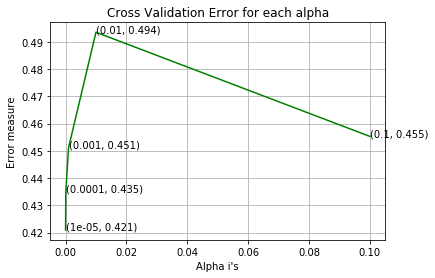

For values of best alpha =  1e-05 The train log loss is: 0.41498119990182175
For values of best alpha =  1e-05 The test log loss is: 0.4209591554752489
Total number of data points : 30000


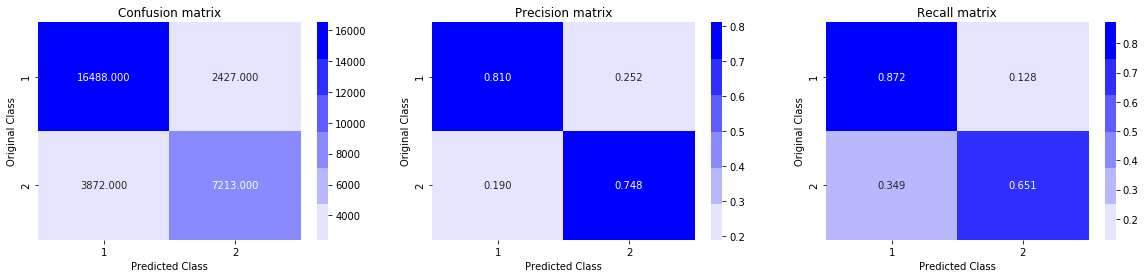

In [148]:
alpha = [10 ** x for x in range(-5, 0)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(best_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(best_train, y_train)
    predict_y = sig_clf.predict_proba(best_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(best_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(best_train, y_train)

predict_y = sig_clf.predict_proba(best_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(best_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y)) 
plot_confusion_matrix(y_test, predicted_y)

In this we have alpha as the hyperparameter which we have to tune is 1e-5 which gives the lowest log loss of 42.09%.

And we observe that the precision recall is also fairly similary , as matter of fact recall for class 2 here is lower than that of recall for logistic regression.

<h2> 4.6 XGBoost Hyperparameter Tuning Using Random Search </h2>

In [149]:
print(transformed_train.shape)
print(transformed_test.shape)

(70000, 2000)
(30000, 2000)


In [151]:
word2tfidf_train = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [152]:
df_train.shape

(70000, 2000)

In [153]:
df_test.shape

(30000, 2000)

In [154]:
X_train.index = df_train.index

In [155]:
final_train = pd.merge(X_train, df_train, left_index=True, right_index=True)

In [156]:
X_test.index = df_test.index 

In [157]:
final_test = pd.merge(X_test, df_test, left_index=True, right_index=True)
final_test.shape

(30000, 2032)

In [160]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
from tqdm import tqdm_notebook
import en_core_web_sm

nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')
vecs_train1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
X_train.question1.fillna("a",inplace= True)
for qu1 in tqdm_notebook(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs_train1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs_train1)

In [161]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
from tqdm import tqdm_notebook
import en_core_web_sm

nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')
vecs_train2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
X_train.question2.fillna("a",inplace= True)
for qu1 in tqdm_notebook(list(X_train['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs_train2.append(mean_vec1)
X_train['q2_feats_m'] = list(vecs_train2)

In [162]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
from tqdm import tqdm_notebook
import en_core_web_sm

nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')
vecs_test1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
X_test.question1.fillna("a",inplace= True)
for qu1 in tqdm_notebook(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs_test1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs_test1)

In [163]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
from tqdm import tqdm_notebook
import en_core_web_sm

nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')
vecs_test2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
X_test.question2.fillna("a",inplace= True)
for qu1 in tqdm_notebook(list(X_test['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs_test2.append(mean_vec1)
X_test['q2_feats_m'] = list(vecs_test2)

In [164]:
X_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'questions_train',
       'q1_feats_m', 'q2_feats_m'],
      dtype='object')

In [165]:
train_df_q1 = pd.DataFrame(X_train['q1_feats_m'].values.tolist(), index= X_train.index)

In [166]:
train_df_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
train_df_q2 = pd.DataFrame(X_train['q2_feats_m'].values.tolist(), index= X_train.index)
train_df_q2.head()


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
train_df_q1['id']=X_train['id']

In [169]:
train_df_q2['id']=X_train['id']

In [170]:
merged_train= train_df_q1.merge(train_df_q2,on='id',how='left')

In [171]:
final_train= X_train.merge(merged_train,on='id',how='left')

In [172]:
final_train.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,282871,402892,68310,Can I link my Google adsense to my YouTube cha...,What are the applications and limitations of a...,1,1,78,101,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,220551,59099,66132,What do the rest of the Indians think about Ka...,What do people from other states think of Kann...,1,3,55,53,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,179501,275421,275422,What are the advantages of removing the headph...,Why is Apple really removing the headphone jac...,1,1,73,81,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,113223,185095,83935,I don't know how to move on from my past relat...,How can I move on from my past relationship?,2,1,72,44,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,202895,305335,305336,Which airline offers best economy seat comfort...,If you have an option to work with either Emir...,1,1,74,100,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
final_train.drop(['id','qid1','qid2','question1','question2'],axis=1,inplace=True)

In [175]:
test_df_q1 = pd.DataFrame(X_test['q1_feats_m'].values.tolist(), index= X_test.index)

In [176]:
test_df_q2 = pd.DataFrame(X_test['q2_feats_m'].values.tolist(), index= X_test.index)

In [177]:
test_df_q1['id']=X_test['id']

In [178]:
test_df_q2['id']=X_test['id']

In [179]:
merged_test= test_df_q1.merge(test_df_q2,on='id',how='left')

In [180]:
final_test= X_test.merge(merged_test,on='id',how='left')
final_test.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,135964,217034,217035,Which is better Xiaomi Mi Max or Le Eco Le 2?,What are your views on Xiaomi's Mi MAX?,1,1,45,39,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90472,62415,50767,Which according to you is the best movie of al...,What are the 5 best movies of all time?,5,11,77,39,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,296844,2574,18273,Where can I get wonderful flavors on cupcakes ...,Where can I found different flavours for cupca...,8,9,60,64,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4015,7950,7951,Do vegetarians feed their dogs with meat?,Do vegetarians or people that don't eat meat f...,1,1,41,84,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,190991,269055,290224,Bundlr: What is the best social bookmarking site?,What are the best social bookmarking sites?,1,1,49,43,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
final_test.drop(['id','qid1','qid2','question1','question2'],axis=1,inplace=True)b


In [183]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
clf_xgb = xgb.XGBClassifier()
parameters={
    'n_estimators':[10, 50, 100, 150, 200, 300], 
    'max_depth':[3,4,5,6],
    'learning_rate':[0.05,0.10,0.15,0.20,0.25],
    'gamma':[0.0,0.1,0.2]
    }


clf=RandomizedSearchCV(clf_xgb,parameters, cv=2,scoring="roc_auc",verbose=3, return_train_score=True)

In [186]:
final_train.drop(["questions_train","q1_feats_m","q2_feats_m"],axis=1,inplace=True)

In [190]:
final_test.drop(["questions_test","q1_feats_m","q2_feats_m"],axis=1,inplace=True)

In [187]:
set1= clf.fit(final_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_estimators=150, max_depth=3, learning_rate=0.1, gamma=0.2 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=150, max_depth=3, learning_rate=0.1, gamma=0.2, score=(train=0.918, test=0.912), total=   6.6s
[CV] n_estimators=150, max_depth=3, learning_rate=0.1, gamma=0.2 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  n_estimators=150, max_depth=3, learning_rate=0.1, gamma=0.2, score=(train=0.919, test=0.913), total=   5.6s
[CV] n_estimators=200, max_depth=4, learning_rate=0.15, gamma=0.1 ....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, learning_rate=0.15, gamma=0.1, score=(train=0.937, test=0.917), total=   9.4s
[CV] n_estimators=200, max_depth=4, learning_rate=0.15, gamma=0.1 ....
[CV]  n_estimators=200, max_depth=4, learning_rate=0.15, gamma=0.1, score=(train=0.938, test=0.917), total=   9.6s
[CV] n_estimators=50, max_depth=4, learning_rate=0.1, gamma=0.2 ......
[CV]  n_estimators=50, max_depth=4, learning_rate=0.1, gamma=0.2, score=(train=0.911, test=0.906), total=   2.9s
[CV] n_estimators=50, max_depth=4, learning_rate=0.1, gamma=0.2 ......
[CV]  n_estimators=50, max_depth=4, learning_rate=0.1, gamma=0.2, score=(train=0.911, test=0.906), total=   2.9s
[CV] n_estimators=200, max_depth=5, learning_rate=0.05, gamma=0.0 ....
[CV]  n_estimators=200, max_depth=5, learning_rate=0.05, gamma=0.0, score=(train=0.928, test=0.915), total=  11.8s
[CV] n_estimators=200, max_depth=5, learning_rate=0.05, gamma=0.0 ....
[CV]  n_estimators=200, max_depth=5, learning_rate=0.05, gamma=0.0, score=

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


In [188]:
print(clf.best_estimator_)

print(clf.score(final_train,y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.9302923731794384


In [191]:
clf_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
 
clf_xgb.fit(final_train, y_train)
train_predict=clf_xgb.predict_proba(final_train)[:,1]
test_predict= clf_xgb.predict_proba(final_test)[:,1]

print("The test log loss is:",log_loss(y_test, test_predict, labels=clf_xgb.classes_, eps=1e-15))

The test log loss is: 0.3383940671049103


Total number of data points : 30000


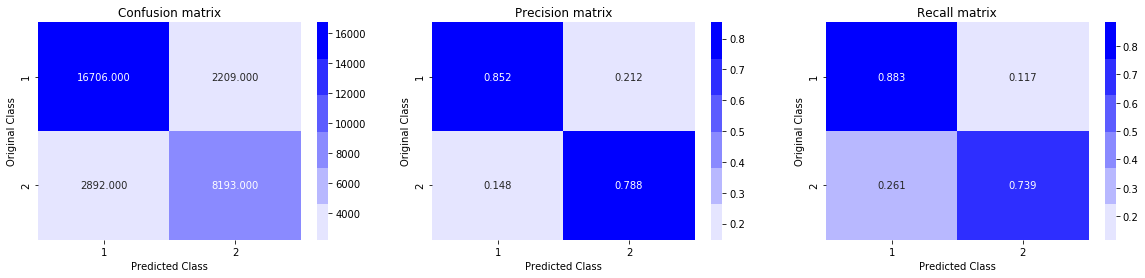

In [192]:
predicted_y =np.array(test_predict>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

First thing to notice here is the improved recall for class 2 and also slight improvement in the overall precision recall 

Hyperparamter tuning is done through random search and we found learning rate = 0.1 max-depth =6 and gamma value of 0.2 resulted in the log-loss of 40% which is the lowest among all three and hence we can conclude the that XGboost performs that the our linear models like logistic regression and support vector machines

## Best K Features

Now let's check the performance of the model when we select best 100 features

In [193]:
best_features = SelectKBest(score_func=chi2,k=100)
best_features.fit(final_train,y_train)

best_train = best_features.transform(final_train)
best_test = best_features.transform(final_test)

In [194]:
best_train.shape

(70000, 100)

In [195]:
best_test.shape

(30000, 100)

In [197]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
clf_xgb = xgb.XGBClassifier()
parameters={
    'n_estimators':[10, 50, 100, 150, 200, 300], 
    'max_depth':[3,4,5,6],
    'learning_rate':[0.05,0.10,0.15,0.20,0.25],
    'gamma':[0.0,0.1,0.2]
    }


clf=RandomizedSearchCV(clf_xgb,parameters, cv=2,scoring="roc_auc",verbose=3, return_train_score=True)

In [198]:
set1= clf.fit(best_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_estimators=200, max_depth=4, learning_rate=0.2, gamma=0.0 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, max_depth=4, learning_rate=0.2, gamma=0.0, score=(train=0.942, test=0.917), total=   4.4s
[CV] n_estimators=200, max_depth=4, learning_rate=0.2, gamma=0.0 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, learning_rate=0.2, gamma=0.0, score=(train=0.943, test=0.917), total=   4.5s
[CV] n_estimators=100, max_depth=4, learning_rate=0.2, gamma=0.2 .....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, learning_rate=0.2, gamma=0.2, score=(train=0.930, test=0.915), total=   2.4s
[CV] n_estimators=100, max_depth=4, learning_rate=0.2, gamma=0.2 .....
[CV]  n_estimators=100, max_depth=4, learning_rate=0.2, gamma=0.2, score=(train=0.932, test=0.916), total=   2.4s
[CV] n_estimators=150, max_depth=6, learning_rate=0.05, gamma=0.2 ....
[CV]  n_estimators=150, max_depth=6, learning_rate=0.05, gamma=0.2, score=(train=0.931, test=0.915), total=   5.0s
[CV] n_estimators=150, max_depth=6, learning_rate=0.05, gamma=0.2 ....
[CV]  n_estimators=150, max_depth=6, learning_rate=0.05, gamma=0.2, score=(train=0.932, test=0.916), total=   5.0s
[CV] n_estimators=150, max_depth=3, learning_rate=0.15, gamma=0.0 ....
[CV]  n_estimators=150, max_depth=3, learning_rate=0.15, gamma=0.0, score=(train=0.923, test=0.914), total=   2.8s
[CV] n_estimators=150, max_depth=3, learning_rate=0.15, gamma=0.0 ....
[CV]  n_estimators=150, max_depth=3, learning_rate=0.15, gamma=0.0, scor

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


In [199]:
print(clf.best_estimator_)

print(clf.score(best_train,y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.9335389274741777


In [201]:
clf_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
 
clf_xgb.fit(best_train, y_train)
train_predict=clf_xgb.predict_proba(best_train)[:,1]
test_predict= clf_xgb.predict_proba(best_test)[:,1]

print("The test log loss is:",log_loss(y_test, test_predict, labels=clf_xgb.classes_, eps=1e-15))

The test log loss is: 0.34091855619619293


Total number of data points : 30000


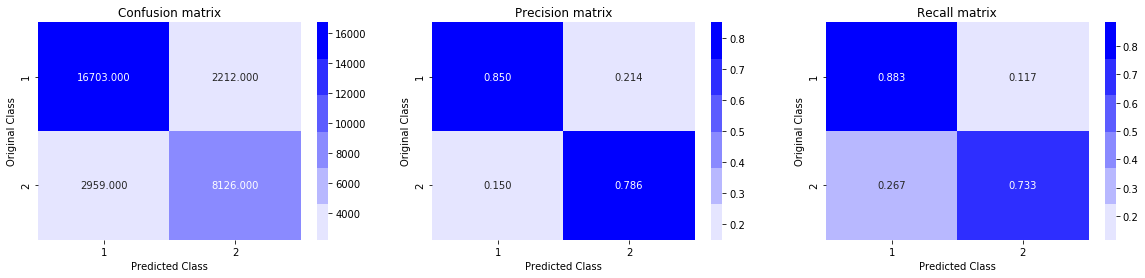

In [202]:
predicted_y =np.array(test_predict>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

We can see that when we selected best 100 features and then train our model we have an increase in the test log-loss

In [204]:
#Refer->http://zetcode.com/python/prettytable/
#Refer->https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.percentile.html
#Refer->https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.round_.html
from prettytable import PrettyTable
x=PrettyTable()

x.field_names=["S.No","Model","Best Hyperparameter","Log-Loss"] #column headers

x.add_row(["1.","Logistic Regression(best-800)", "alpha =0.01",0.43764])
x.add_row(["2.","Linear SVM(best-800)","alpha =1e-05", 0.42095])
x.add_row(["3.","XGBoost","learning_rate=0.1,max_depth=6,gamma=0.2", 0.3383])
x.add_row(["4.","XGBoost(best-100)","learning_rate=0.2,max_depth=4,gamma=0.0", 0.3401])
print(x)

+------+-------------------------------+-----------------------------------------+----------+
| S.No |             Model             |           Best Hyperparameter           | Log-Loss |
+------+-------------------------------+-----------------------------------------+----------+
|  1.  | Logistic Regression(best-800) |               alpha =0.01               | 0.43764  |
|  2.  |      Linear SVM(best-800)     |               alpha =1e-05              | 0.42095  |
|  3.  |            XGBoost            | learning_rate=0.1,max_depth=6,gamma=0.2 |  0.3383  |
|  4.  |       XGBoost(best-100)       | learning_rate=0.2,max_depth=4,gamma=0.0 |  0.3401  |
+------+-------------------------------+-----------------------------------------+----------+


# Conclusion

1. The first and the foremost step is to identify the problem statement and to identify the cost of mis-classification.

2. Based on the problem we then identified that it is a classfication task and then chosse the performance indicator which is log-loss. Why we chose log-loss as the KPI is because the cost of misclassification is very high and therefore we need to be absolutely sure about the predicted class and therefore we need to put a high threshold value which is not possible in simple 0 and 1 values

3. Imported Necessary libraries and read the data through pandas library and found out that our data contains around 404K points with 5 features and it also contains 3 null values.

4. We then found that it is a imbalanced dataset by printing the distribution of each class.

5. We then performed some basic exploratory data analysis and found that we have more number of unique question then repeated questions. The maximum number of times a single question is repeated is 157times.

6. We then performed some basic and advnaced features engineering and also cleaning of our text features i.e question1 and question2

7. Then with the help of t-SNE we tried to visualise our data which is in higher dimension to 2-dimensions and 3-dimensions.

8. We then split our data into train and test into 70:30 ratio and then convert our text features into numerical using tf-idf vectorisation.

9. We selected top 800 features with the help of scikit's SelectKbest module with chisquare scoring

10. We then tried different machine learning models like SVM and Logistic Regression(linear model) and done some hyperparameter tuning to each models, plot confusion matrix ,precision and recall matrix

11. We also tried XGBoost(Ensemble model) with all available features and also selected best 100 features and plot the confusion matrix, recall and precision matrix and compared their result.

12. In the end we found that XGBoost with all features performs slightly better than best 100 features
